# Inference with Muse

Muse performs "marginalization with unbiased score estimates", which computationally uses many MAP estimates to better approximate a mostly normal posterior for parameters of interest, given a large latent space which is not of interest.  This dovetails nicely with how most TVB simulations have to assume an enormous *nuisance* latent space due to stochastic integration.

Here we're testing the Jax interface with stochastic neural fields,

https://cosmicmar.com/muse_inference/advanced_examples.html#Jax


In [2]:
%pylab inline
import jax
import jax.numpy as jnp
from muse_inference.jax import JaxMuseProblem
import nfjax.shtlc as lc

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Stochastic neural field

For this to work, we need a model structure that can take advantage of marginalization.

First the local coupling,

In [3]:
# local coupling setup
lmax, nlat, nlon, D = 16, 32, 64, 0.0004
_, L = lc.make_shtdiff(lmax=lmax, nlat=nlat, nlon=nlon, D=D, return_L=True)
np.testing.assert_equal(0, L.imag)
L = L.real.astype('f')

def apply_L(L, x, np=jnp):
    X = np.fft.rfft(x, axis=1)
    X = np.hstack(
        (np.einsum('abc,ca->ba', L, X[:,:lmax]),
         np.zeros((X.shape[0], X.shape[1] - lmax), jnp.complex64)
        )
    )
    y = np.real(np.fft.irfft(X, axis=1))
    return y

x0 = jnp.array(np.random.randn(nlat, nlon).astype('f'))
x1 = apply_L(L, x0)

Then the field simulation:

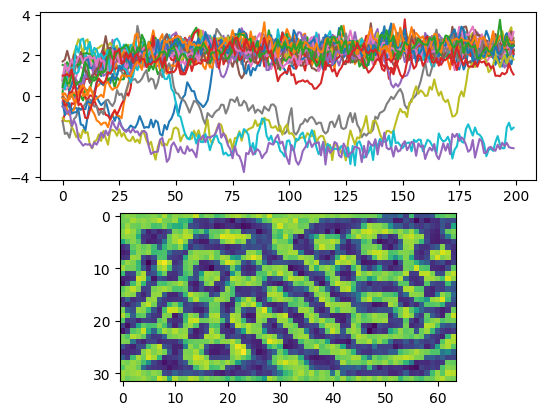

In [4]:
@jax.jit
def simulate(dt, x0, k, sig, zt):
    sqrt_dt = jnp.sqrt(dt)
    def f(x, z):
        lx = apply_L(L, x, np=jnp)
        x = x + dt * (x - x**3/3 + k * lx) + sqrt_dt * z * sig
        return x, x
    _, xt = jax.lax.scan(f, x0, zt)
    return xt

key = jax.random.PRNGKey(42)
zt = jax.random.normal(key, (200, ) + x0.shape)
sig = 1.0
dt = 0.1
k = 5.0
xt = simulate(dt, x0, k, sig, zt)

subplot(211); plot(xt[:,:5,:5].reshape((-1, 25)));
subplot(212); imshow(xt[-1])

## adapt problem for Muse interface

Anyway, we can adapt the problem to muse like this:

In [7]:
class MuseField(JaxMuseProblem):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def sample_x_z(self, key, θ):
        x0, log_sig, log_k = θ
        z = jax.random.normal(key, (200, ) + x0.shape)
        x = simulate(dt, x0, jnp.exp(log_k), jnp.exp(log_sig), z)
        return (x, z)

    def logLike(self, x, z, θ):
        return -jnp.sum((x - xt)**2)

    def logPrior(self, θ):
        x0, log_sig, log_k = θ
        e = jnp.sum(x0**2) + log_sig**2 + (log_k - 1.6)**2
        return -e

and run the muse algorithm,

In [8]:
prob = MuseField()
key = jax.random.PRNGKey(0)
θ = x0, jnp.log(sig), jnp.log(k)
(x, z) = prob.sample_x_z(key, θ)
prob.set_x(x)

θ0 = x0*1.1, jnp.log(sig*1.1), jnp.log(k*1.1)
result = prob.solve(θ_start=θ0, rng=jax.random.PRNGKey(1), progress=True)

get_H: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:33<00:00, 15.38s/it]


## check solution 

The recovered hyperparameters match what we used to generate the data:

In [9]:
x0h, sigh, kh = result.θ
sig, jnp.exp(sigh), k, jnp.exp(kh)

(1.0, Array(1.0000006, dtype=float32), 5.0, Array(4.9530354, dtype=float32))

Then, modulo some scale factor (?), we recover the initial conditions:

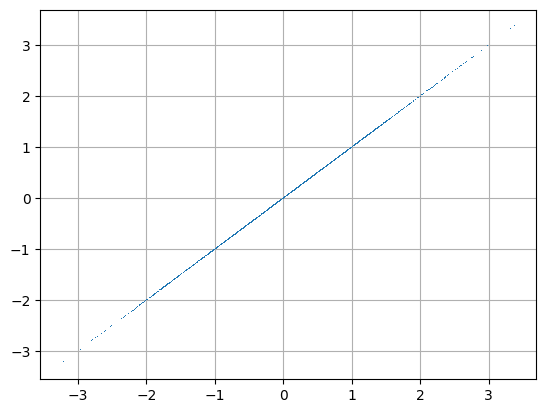

In [10]:
scl = (x0/x0h).mean()
plot(x0h.reshape(-1) * scl, x0.reshape(-1), ',')
grid(1)

## with NUTS

We can also do this with NUTS of course, but interrupted because it takes a long time to run:

In [11]:
from numpyro.infer import MCMC, NUTS, SVI, Trace_ELBO
import numpyro.distributions as dist
import numpyro

def logp(xt=None):
    x0h = numpyro.sample('x0h', dist.Normal(jnp.zeros((nlat, nlon)), 1))
    z = numpyro.sample('z', dist.Normal(jnp.zeros((len(xt), nlat, nlon)), 1))
    k_star = numpyro.sample('k_star', dist.Normal(0, 1))
    sig_star = numpyro.sample('sig_star', dist.Normal(0, 1))
    xth_mu = simulate(dt, x0h, jnp.exp(k_star), jnp.exp(sig_star), z)
    numpyro.sample('xth', dist.Normal(xth_mu, 1), obs=xt)

/Users/duke/.local/share/virtualenvs/nfjax-Y-MGz7Lr/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
nuts_kernel = NUTS(logp)
mcmc = MCMC(nuts_kernel, num_warmup=50, num_samples=50)
rng_key = jax.random.PRNGKey(0)
mcmc.run(rng_key, xt=xt)

sample: 100%|████████████████████████████████████████████████| 100/100 [28:58<00:00, 17.39s/it, 1023 steps of size 6.18e-07. acc. prob=0.84]


NUTS gets predictably stuck with very low step sizes.  A longer warmup might help, but it might take days too. 